# **scNET: Learning Context-Specific Gene and Cell Embeddings by Integrating Single-Cell Gene Expression Data with Protein-Protein Interaction Information**

**Install scnet using pip**

**It may be necessary to restart (not delete) the runtime after installing ScENT in Google Colab. We are working on fixing this issue in future releases.**

In [1]:
# !pip install scnet

**Download example data**

In [2]:
import gdown
download_url = f'https://drive.google.com/uc?id=1C_G14cWk95FaDXuXoRw-caY29DlR9CPi'
output_path = './example.h5ad'
# gdown.download(download_url, output_path, quiet=False)

# Import scNET and model traning

In [3]:
import scNET
#For faster processing in medium to large datasets (e.g. 30K or above cells), the maximum cells batch size can be increased depending on the available GPU memory.

#For GPU with 15GB memory (T4)
scNET.main.MAX_CELLS_BATCH_SIZE = 1024

#For GPU with 24GB memory
#scNET.main.MAX_CELLS_BATCH_SIZE = 3000

#for GPU with 40GB memory
#scNET.main.MAX_CELLS_BATCH_SIZE = 4000

#For GPU with 80GB memory or more
#scNET.main.MAX_CELLS_BATCH_SIZE = 8000

#otherwize, do not change the default value

In [4]:
#To control the cutoff of gene expression, the minimum precetage of cells expressing a gene can be adjusted. The default all expressed genes are considered.
#For example, to consider genes expressed in at least 5% of cells
#scNET.main.EXPRESSION_CUTOFF = 0.05

In [5]:
#For larger dataset (10K or above), containing larger number of subcommunities, the number of encoder layers could be increased to 4 or more. the default value is 3.
scNET.main.NUM_LAYERS = 3

In [6]:
#To control the number of deifferentially expressed genes, the default value is 2000
#For example, to consider 3500 DE genes
scNET.main.DE_GENES_NUM = 3500


## run_scNET arguments:
 **obj (AnnData, optional):** AnnData obj.

  **pre_processing_flag (bool, optional):** If True, perform pre-processing steps.

  **human_flag (bool, optional):** Controls gene name casing in the network.

  **number_of_batches (int, optional):** Number of mini-batches for the training.

  **split_cells (bool, optional):** If True, split by cells instead of edges during training. If using A100 could be True (for 10K cells or less)

  **n_neighbors (int, optional):** Number of neighbors for building the adjacency graph.

  **max_epoch (int, optional):** Max number of epochs for model training (recommended 250-300, and for larger dataset consider also 300-350).

  **model_name (str, optional):** Identifier for saving the model outputs.
  
  **save_model_flag (bool, optional):** If True, save the trained model.
  
  numpy = 1.26.4, python = 3.11.12
  
  무시해도 되는 오류: thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [7]:
import numpy as np
print(np.__version__)


1.26.4


In [8]:
# !pip install numpy==1.26.4 --force-reinstall
# import numpy as np
# print(np.__version__)

**Model Training**

각 세포가 어떤 발현을 가지고 있는 지 딥러닝 모델을 학습시키는 과정.
obj에 담긴 scRNA-seq (단일세포 전사체) 데이터를 받아서 VAE 기반의 딥러닝 모델인 scNET을 훈련시키고**잠재 공간(latent space)**에서 세포의 구조를 학습함
결과적으로 세포를 자동으로 클러스터링하고, 어떤 유전자가 어떤 세포를 대표하는지도 찾아냄

Error Handling: CUDA Out of Memory 발생 시,
- number_of batches = 50 으로 줄이기
- 위의 셀 scNET.main.MAX_CELLS_BATCH_SIZE = 1024
- 100 epoch 훈련시, 1시간 정도가 소요됩니다.


DIY Task 1: Human_flag를 True로 바꾸고 mouse와 인간 데이터 차이 확인 후 분석하기

In [9]:
import scanpy as sc
obj = sc.read_h5ad("./example.h5ad")
scNET.run_scNET(obj, pre_processing_flag=False,
                human_flag=False,
                number_of_batches=30,
                split_cells=True,
                max_epoch=100,
                model_name = "test")


/usr/local/lib/python3.11/dist-packages/scNET/Data/format_h_sapiens.csv
N genes: (11049, 9172)
Highly variable genes: 3500


Training: 100%|██████████| 100/100 [1:51:05<00:00, 66.65s/it]

Best Network AUC: 0.8874933134163631



# Using the model's outputs

**Load all the relevant embeddings**


In [20]:
embedded_genes, embedded_cells, node_features , out_features =  scNET.load_embeddings("test")

**Create Scanpy object based on the reconstructed gene expression**


In [11]:
cell_types = {"0":"Macrophages","1":"Macrophages","2":"CD8 Tcells","3":"Microglia","4":"Cancer","5":"CD4 Tcells","6":"B Cells","10":"Prolifrating Tcells","8":"Cancer","11":"NK"}
obj.obs["Cell Type"] = obj.obs.seurat_clusters.map(cell_types)
recon_obj = scNET.create_reconstructed_obj(node_features, out_features, obj)

**Plot marker genes**

그래프 해석: UMAP(Uniform Manifold Approximation and Projection)
고차원 표현을 2D로 투영하여
비슷한 세포는 가까이, 다른 세포는 멀리 배치되도록 시각화하는 차원 축소 기법.



DIY Task 2: 다른 마커 유전자를 확인하여 의미 있는 결과를 발견해 보시오.세포 유형을 잘 나타내는 유전자인지 시각적으로 판단하여 가설을 내리시오.

**과제 낼 때 아래 유전자 예시 비우고 낼 것 **

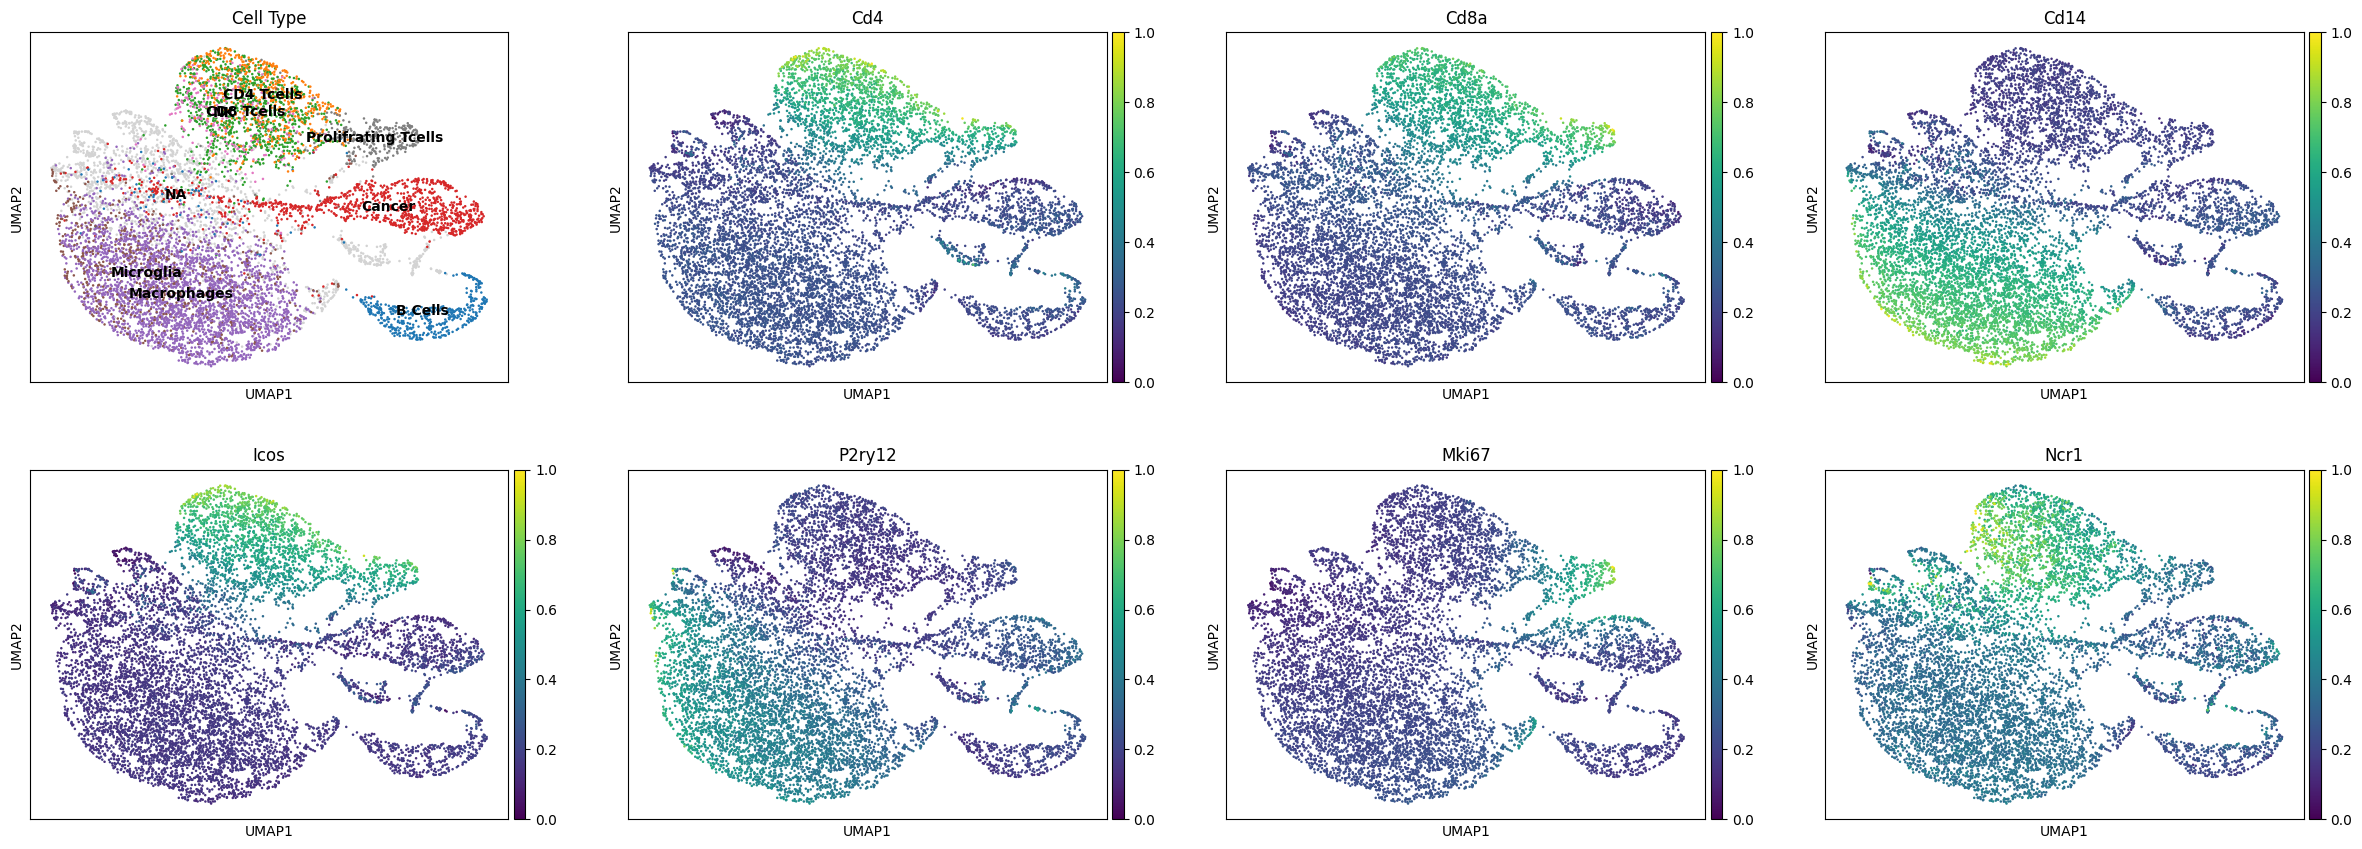

In [12]:
sc.pl.umap(recon_obj, color=["Cell Type","Cd4","Cd8a","Cd14","Icos","P2ry12","Mki67","Ncr1"], show=True, legend_loc='on data')

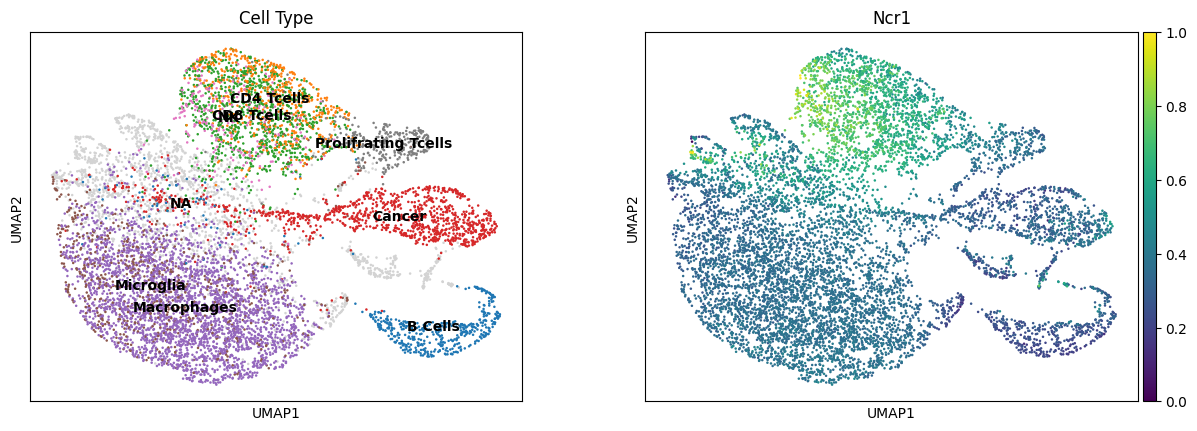

In [21]:
sc.pl.umap(recon_obj, color=["Cell Type","Ncr1"], show=True, legend_loc='on data')

**Example of Calculating Marker Gene AUPR**

1. 각 marker gene의 발현량을 기준으로
해당 세포 타입과 아닌 세포를 binary 분류합니다.

2. 그 결과로 정밀도-재현율(Precision-Recall) 곡선을 그릴 수 있습니다.
3. 그리고 그 면적(AUPR)을 계산해서 그 유전자가 얼마나 “좋은 마커”인지 수치로 알 수 있습니다.


 DIY Task 3 : Task 2에서 만든 자신의 가설을 정량적으로 검증하시오.

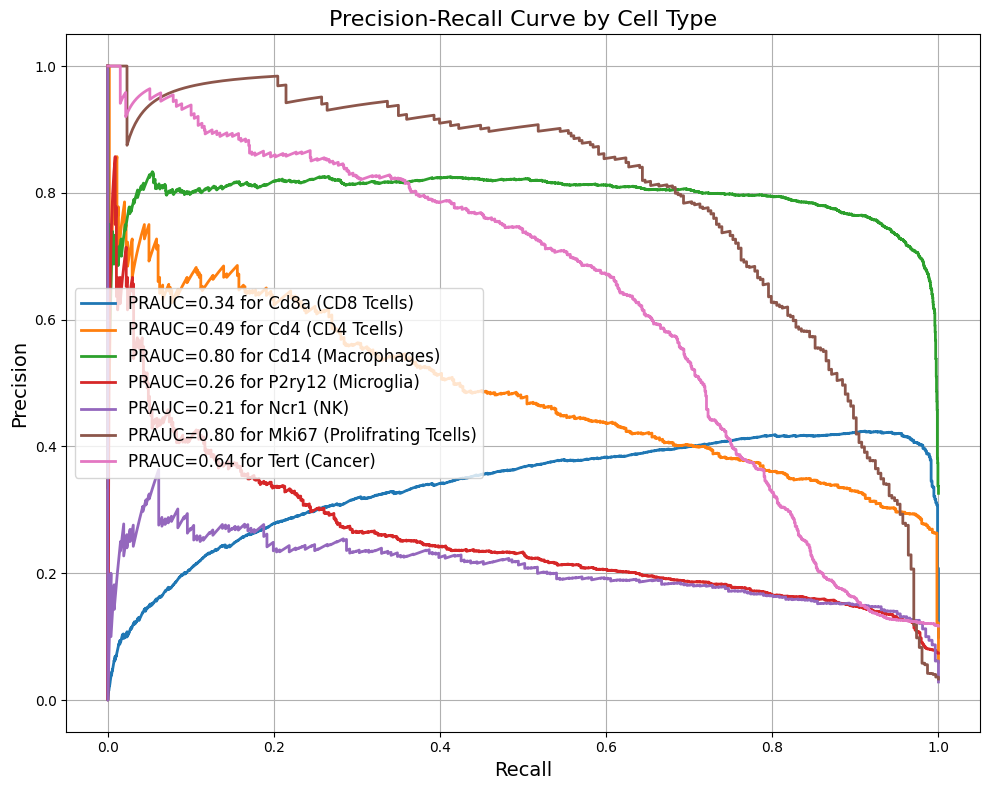

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc
from itertools import cycle

def calculate_marker_gene_aupr(adata, marker_genes, cell_types):
    colors = cycle(['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2'])
    plt.figure(figsize=(10, 8))

    for marker_gene, cell_type, color in zip(marker_genes, cell_types, colors):
        gene_expression = adata[:, marker_gene].X.toarray().flatten()
        binary_labels = (adata.obs["Cell Type"].isin(cell_type)).astype(int)

        precision, recall, _ = precision_recall_curve(binary_labels, gene_expression)
        aupr = auc(recall, precision)
        plt.plot(recall, precision, color=color, lw=2,
                 label=f'PRAUC={aupr:.2f} for {marker_gene} ({cell_type[0]})')

    plt.xlabel('Recall', fontsize=14)
    plt.ylabel('Precision', fontsize=14)
    plt.title('Precision-Recall Curve by Cell Type', fontsize=16)
    plt.legend(loc="best", fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    plt.show()
calculate_marker_gene_aupr(recon_obj,['Cd8a','Cd4','Cd14',"P2ry12","Ncr1","Mki67","Tert"],[["CD8 Tcells"],['CD4 Tcells'], ['Macrophages'], ['Microglia'], ["NK"],["Prolifrating Tcells"],["Cancer"]])




**Propagation based signature projection for actvation of Tcells**


run_signature():
세포 전체에서 얼마나 활성화되어 있는지를
scNET이 학습한 latent space 기반 그래프에서 전파시켜 계산하는 과정

예시: ["Zap70", "Lck", "Fyn", "Cd3g", "Cd28", "Lat"]
T cell 신호전달 경로에서 중요한 유전자.
즉, 이 시그니처가 높게 나오는 세포는 T세포가 활성화 되었다고 추정할 수 있다.


DIY Task 4: 암세포가 활발히 확장 중인 세포를 예측 하시오.
또는, 자신이 발견한 마커 유전자를 활발히 사용하는 세포들이 같은 cluster에 속해 있는지 증명하시오.


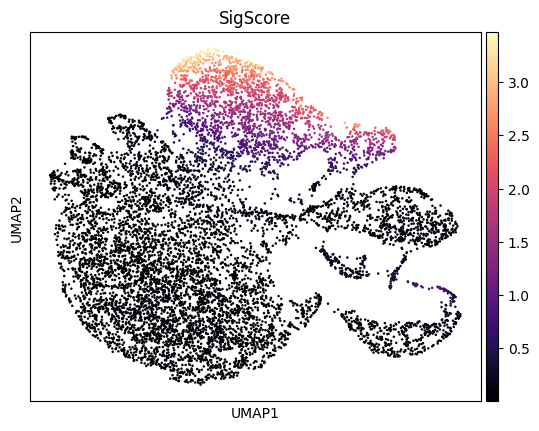

array([0.88388453, 0.54295409, 0.03817588, ..., 0.0384674 , 0.02678034,
       2.40482248])

In [14]:
scNET.run_signature(recon_obj, up_sig=["Zap70","Lck","Fyn","Cd3g","Cd28","Lat"],alpha = 0.9)
# 예시 1: T cell activation

**Tumor aggression**

**Task 4의 cancer-specific gene 유전자: 정답 예시 이므로 지워서 제출 요망 !!**

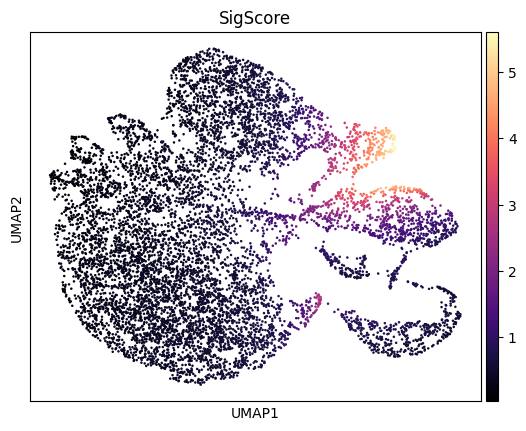

array([3.73847471, 0.5681184 , 1.10943287, ..., 0.747629  , 3.22458988,
       0.48202112])

In [23]:
scNET.run_signature(
    recon_obj,
    up_sig=["MYC", "TP53", "TERT", "CDK1", "CCNB1", "BIRC5"],
    alpha=0.9
)


**Creating the co-embedded network, is it modular?**

DIY Task 5. 얼마나 뚜렷하게 기능적으로 구분 되는지 점수를 구하시오.

In [16]:
import networkx as nx
net, mod = scNET.build_co_embeded_network(embedded_genes, node_features)
print(f"The network mdularity: {mod}")

The network mdularity: 0.8128488758806319
